In [1]:
import torch
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
df = pl.read_parquet("data/out/movie-script-dataset.parquet")
embeddings = torch.load("data/out/scripts-embedded.pt", weights_only=True)
print(df.shape)
print(embeddings.shape)
print(embeddings.dtype)

(110, 9)
torch.Size([110, 1024])
torch.float32


In [66]:
genre_counts = df["genre"].str.replace_all(r'[\s]', '')\
    .str.replace_all(r'[,]+', ',')\
    .str.split(",").explode().value_counts()\
    .sort(pl.col("count"), descending=True)

genre,count
str,u32
"""Adventure""",55
"""Animation""",47
"""Drama""",47
"""Comedy""",45
"""Action""",39
"""Family""",24
"""Fantasy""",20
"""Crime""",16
"""Thriller""",15


In [3]:
embeddings_duplicated_over_0 = embeddings.unsqueeze(1).expand(-1, embeddings.shape[0], -1)
embeddings_duplicated_over_1 = embeddings.unsqueeze(0).expand(embeddings.shape[0], -1, -1)
print(embeddings_duplicated_over_0.shape)
print(embeddings_duplicated_over_1.shape)

print(
    (embeddings_duplicated_over_0[1, 13, :] == embeddings[1, :]).all()
)

print(
    (embeddings_duplicated_over_1[13, 1, :] == embeddings[1, :]).all()
)

torch.Size([110, 110, 1024])
torch.Size([110, 110, 1024])
tensor(True)
tensor(True)


In [4]:
cos_sim_layer = torch.nn.CosineSimilarity(dim=2)

cos_sim = cos_sim_layer(embeddings_duplicated_over_0, embeddings_duplicated_over_1)

print(cos_sim.shape)

dotprod = torch.tensordot(embeddings, embeddings, dims=([1], [1]))

print(dotprod.shape)

torch.Size([110, 110])
torch.Size([110, 110])


In [5]:
np_cos_sim = cos_sim.flatten().numpy()
np_dotprod = dotprod.flatten().numpy()

csdf = pl.DataFrame(np_cos_sim)
dtdf = pl.DataFrame(np_dotprod)

csdf.columns = ["cos"]
dtdf.columns = ["dot"]

simdf = csdf.with_row_index().join(
    dtdf.with_row_index(),
    on=pl.col("index"),
    how="inner"
)
print(simdf.shape)
simdf.select(pl.col("cos", "dot")).corr()


(12100, 3)


cos,dot
f64,f64
1.0,0.751784
0.751784,1.0


In [6]:
def rank_similarity(
    movie_title: str,
    rank_expr: str | pl.Expr,
    print_similarity_correlation: bool = True
) -> pl.DataFrame:
    
    idx = get_index_in_df_from_title(movie_title)
    

    simdf = pl.DataFrame(
        {"dotprod": dotprod[idx].numpy(), "cos_sim": cos_sim[idx].numpy()}
    ).with_row_index()\
        .join(
            df.select(pl.col("index", "movie_title")),
            on = pl.col("index"),
            how = "inner"
        )\
        .filter(pl.col("index") != idx) # filter out exact match
    
    if print_similarity_correlation is True:
        print_similarity_correlation_helper(simdf)

    return simdf.sort(rank_expr, descending=True)

def get_index_in_df_from_title(movie_title: str) -> int:
    idx = df.filter(pl.col("movie_title").str.to_lowercase() == movie_title.lower()).select(pl.col("index"))
    if len(idx) < 1:
        raise ValueError(f"Could not find movie {movie_title}")
    elif len(idx) > 1:
        raise ValueError(f"Found multiple matches for movie {movie_title}\n{idx}")
    else:
        idx = idx[0, "index"]
        return idx
    
def print_similarity_correlation_helper(
    data: pl.DataFrame,
    col1: str = "dotprod",
    col2: str = "cos_sim"
) -> None:
    corr_dotprod_cos = data.select(pl.col(col1, col2)).corr()\
            [0, col2]
    msg = f"Correlation between dot product and cosine similarity: {corr_dotprod_cos:.3f}"
    print(msg)
    

In [7]:
cfg = pl.Config()
cfg.set_tbl_rows(2000)
rnd_movie = df.sample(1)[0, "movie_title"]
print(rnd_movie)
ranked_similarity = rank_similarity(rnd_movie, "dotprod")\

display(ranked_similarity.head(8))
print("...")
display(ranked_similarity.tail(8))

Nope
Correlation between dot product and cosine similarity: 0.690


index,dotprod,cos_sim,movie_title
u32,f32,f32,str
101,182.245987,0.851217,"""Top Gun"""
3,181.408493,0.858929,"""30 Minutes or Less"""
50,180.308868,0.872768,"""Glass Onion"""
1,178.914642,0.863452,"""15 Minutes"""
0,178.096878,0.834413,"""12 Angry Men"""
27,176.401199,0.841233,"""The Bourne Supremacy"""
99,176.182968,0.824865,"""Star Wars Episode V The Empire…"
20,176.149063,0.847261,"""Avengers: Endgame"""


...


index,dotprod,cos_sim,movie_title
u32,f32,f32,str
16,159.408264,0.836849,"""Amsterdam"""
71,159.295746,0.78641,"""Luca"""
41,159.262665,0.79336,"""Elemental"""
55,158.967621,0.765752,"""Harry Potter and the Half Bloo…"
70,157.320953,0.771784,"""The Lord of the Rings The Retu…"
90,157.320953,0.771784,"""Schindler's List"""
36,155.927597,0.809833,"""The Curious Case of Benjamin B…"
32,138.126892,0.670556,"""Cidade de Deus (City of God)"""


In [8]:
embeddings.shape

torch.Size([110, 1024])

In [9]:
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(n_components=2)

embeddings_lowdim = reducer.fit_transform(embeddings)
embeddings_lowdim.shape

/Users/anders/Desktop/learning/internet-movie-script-dataset/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anders/Desktop/learning/internet-movie-script-dataset/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(110, 2)

In [19]:
df.head()

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,year
u32,str,date,str,str,str,str,str,i32
0,"""12 Angry Men""",null,"""1. NOTE: The notes on characte…","""Crime,Drama""",null,"""12 Angry Men""","""Google Search""",1957
1,"""15 Minutes""",null,"""FADE IN on the words CZECH…","""Action,Crime,Drama,Thriller""","""John Hertzfield""","""15 Minutes""","""https://www.kaggle.com/dataset…",2001
2,"""2012""",2008-02-01,"""OVER BLACK …","""Action,Adventure,Drama,SciFi,T…","""Roland Emmerich,Harald Kloser""","""2012""","""https://www.kaggle.com/dataset…",2008
3,"""30 Minutes or Less""",2009-12-01,"""The following is very loosely …","""Action,Adventure,Comedy""","""Michael Diliberti,Matthew Sull…","""30 Minutes or Less""","""https://www.kaggle.com/dataset…",2009
4,"""48 Hrs""",null,"""FADE IN: OPEN…","""Action,Comedy,Thriller""","""Steven E. De Souza,Walter Hill…","""48 Hrs""","""https://www.kaggle.com/dataset…",1982


In [62]:
df = df.with_columns(
    main_genre = \
    pl.when(pl.col("genre").str.contains('Fantasy'))
    .then(pl.lit("Fantasy"))
    .when(pl.col("genre").str.contains('Crime'))
    .then(pl.lit("Crime"))
    .when(pl.col("genre").str.contains('Musical'))
    .then(pl.lit("Musical"))
    .when(pl.col("genre").str.contains('Horror'))
    .then(pl.lit("Horror"))
    .when(pl.col("genre").str.contains('SciFi'))
    .then(pl.lit("SciFi"))
    .when(pl.col("genre").str.contains('Thriller'))
    .then(pl.lit("Thriller"))
    .when(
        pl.col("genre").str.contains('Animation') & 
        pl.col("genre").str.contains("Comedy")
    )
    .then(pl.lit("Comedy"))
    .when(pl.col("genre").str.contains("Adventure"))
    .then(
        pl.when(pl.col("genre").str.contains("Animation"))
        .then(pl.lit("Animation"))
        .when(pl.col("genre").str.contains("Comedy"))
        .then(pl.lit("Adventure"))
        .when(pl.col("genre").str.contains("Action"))
        .then(pl.lit("Action"))
        .otherwise(pl.lit("Adventure"))
    )
    .when(pl.col("genre").str.contains("Comedy"))
    .then(pl.lit("Comedy"))
    .when(pl.col("genre").str.contains("Drama"))
    .then(pl.lit("Drama"))
    .when(pl.col("genre").str.contains("Action"))
    .then(pl.lit("Action"))
    .when(pl.col("genre").str.contains("Animation"))
    .then(pl.lit("Animation"))
    .when(pl.col("genre").is_null())
    .then(pl.lit(None))
    .otherwise(pl.lit("Other"))

    ,is_animated = pl.col("genre").str.contains("Animation")
)
df.select(pl.col("movie_title", "genre", "main_genre", "is_animated"))

movie_title,genre,main_genre,is_animated
str,str,str,bool
"""12 Angry Men""","""Crime,Drama""","""Crime""",false
"""15 Minutes""","""Action,Crime,Drama,Thriller""","""Crime""",false
"""2012""","""Action,Adventure,Drama,SciFi,T…","""SciFi""",false
"""30 Minutes or Less""","""Action,Adventure,Comedy""","""Adventure""",false
"""48 Hrs""","""Action,Comedy,Thriller""","""Thriller""",false
"""9""","""Adventure,Animation,Drama,Fant…","""Fantasy""",true
"""A Few Good Men Script""","""Crime,Drama,Mystery,Thriller""","""Crime""",false
"""A Most Violent Year""","""Action,Crime,Drama""","""Crime""",false
"""A Scanner Darkly""","""Animation,Crime,Drama""","""Crime""",true


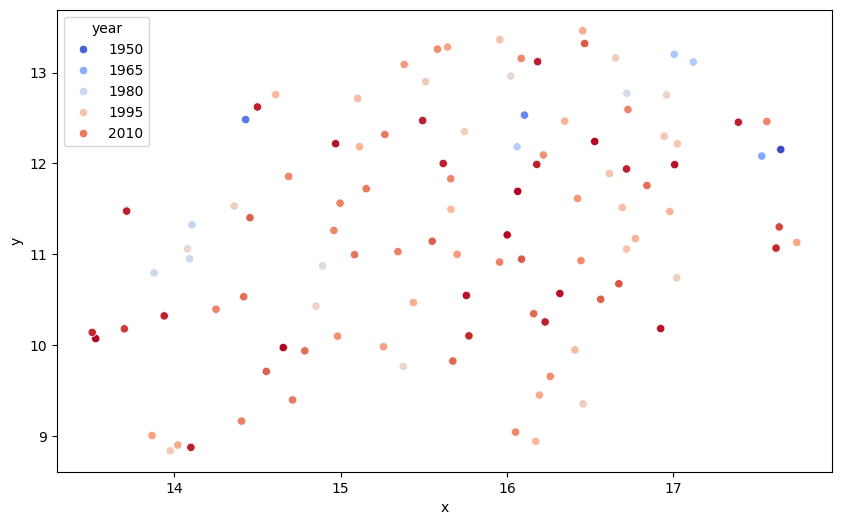

In [64]:
emblow = pd.DataFrame(embeddings_lowdim, columns = ['x', 'y'])
emblow = pl.from_pandas(emblow).with_row_index().join(
    df.with_columns(
        script_length = pl.col("script").str.len_chars()
    ).select(pl.col("index", "movie_title", "year", "genre", "main_genre", "script_length")),
    on = 'index',
    how = 'inner'
)

fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow,
    x='x',
    y='y',
    hue='year',
    palette='coolwarm'
)

plt.show()

In [ ]:
import itertools

df = df.with_columns(
    # genre is a comma separated string with no spaces, and no duplicates within the same string
    pl.col("genre").str.split(",")
    .map_elements(lambda x: [i for i in x if i != ""])
    .map_elements(lambda genres: list(itertools.combinations(sorted(genres), 2)))
    .alias("genre_combinations")
)

df["genre_combinations"].explode().value_counts(sort=True)

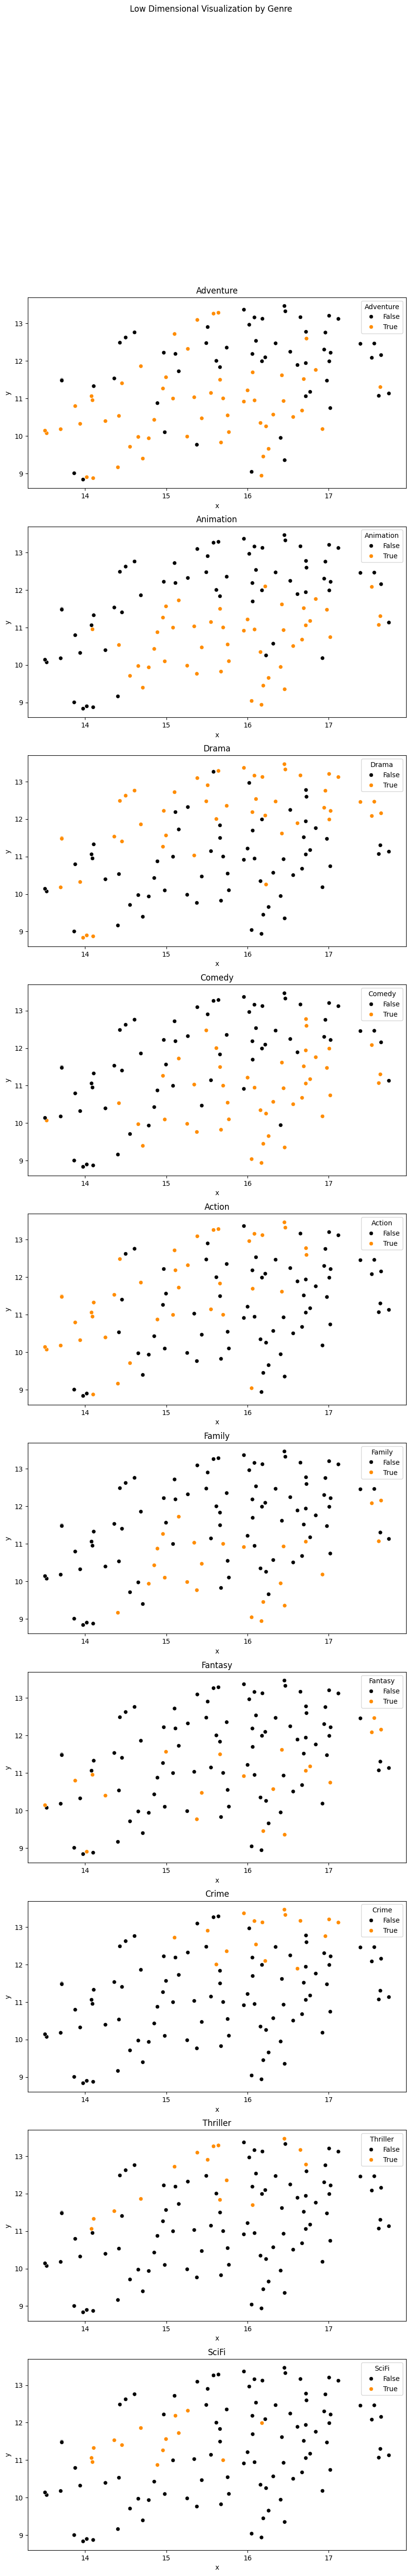

In [76]:
genre_counts = df["genre"].str.replace_all(r'[\s]', '')\
    .str.replace_all(r'[,]+', ',')\
    .str.split(",").explode().value_counts()\
    .sort(pl.col("count"), descending=True)

nplots = 10

fig, axes = plt.subplots(nplots,1,figsize=(10,6*nplots))
fig.suptitle("Low Dimensional Visualization by Genre")

for i in range(nplots):

    sns.scatterplot(
        emblow.with_columns(
            pl.col("genre").str.contains(genre_counts[i, "genre"])
            .alias(genre_counts[i, "genre"])
        ),
        x='x',
        y='y',
        hue=genre_counts[i, "genre"],
        ax=axes[i],
        palette=["k", "darkorange"]
    )
    axes[i].set_title(genre_counts[i, "genre"])

plt.show()

In [127]:
label_movies = [
    '12 Angry Men',
 'Aladdin',
 'Avatar',
 'Avengers: Endgame',
 'Barbie',
 'Black Panther Wakanda Forever',
 'Cidade de Deus (City of God)',
 'Coco',
 'The Dark Knight',
 'Fight Club',
 'Forrest Gump',
 "The Bourne Identity",
 'Frozen (Disney)',
 'The Godfather',
 'Fantastic Mr Fox',
 'Nope',
 'The LEGO Movie',
 'Coraline',
 'Harry Potter and the Half Blood Prince',
 'Inception',
 'The Shawshank Redemption',
 'Shrek',
 'Interstellar',
 "It's a Wonderful Life",
 'The Lord of the Rings The Fellowship of the Ring',
 'The Matrix',
 'Star Wars Episode V The Empire Strikes Back',
 'The Nightmare Before Christmas',
 'Pulp Fiction',
 'Saving Private Ryan',
 'Wall-E',
 'Up'
]
print(len(label_movies))

32


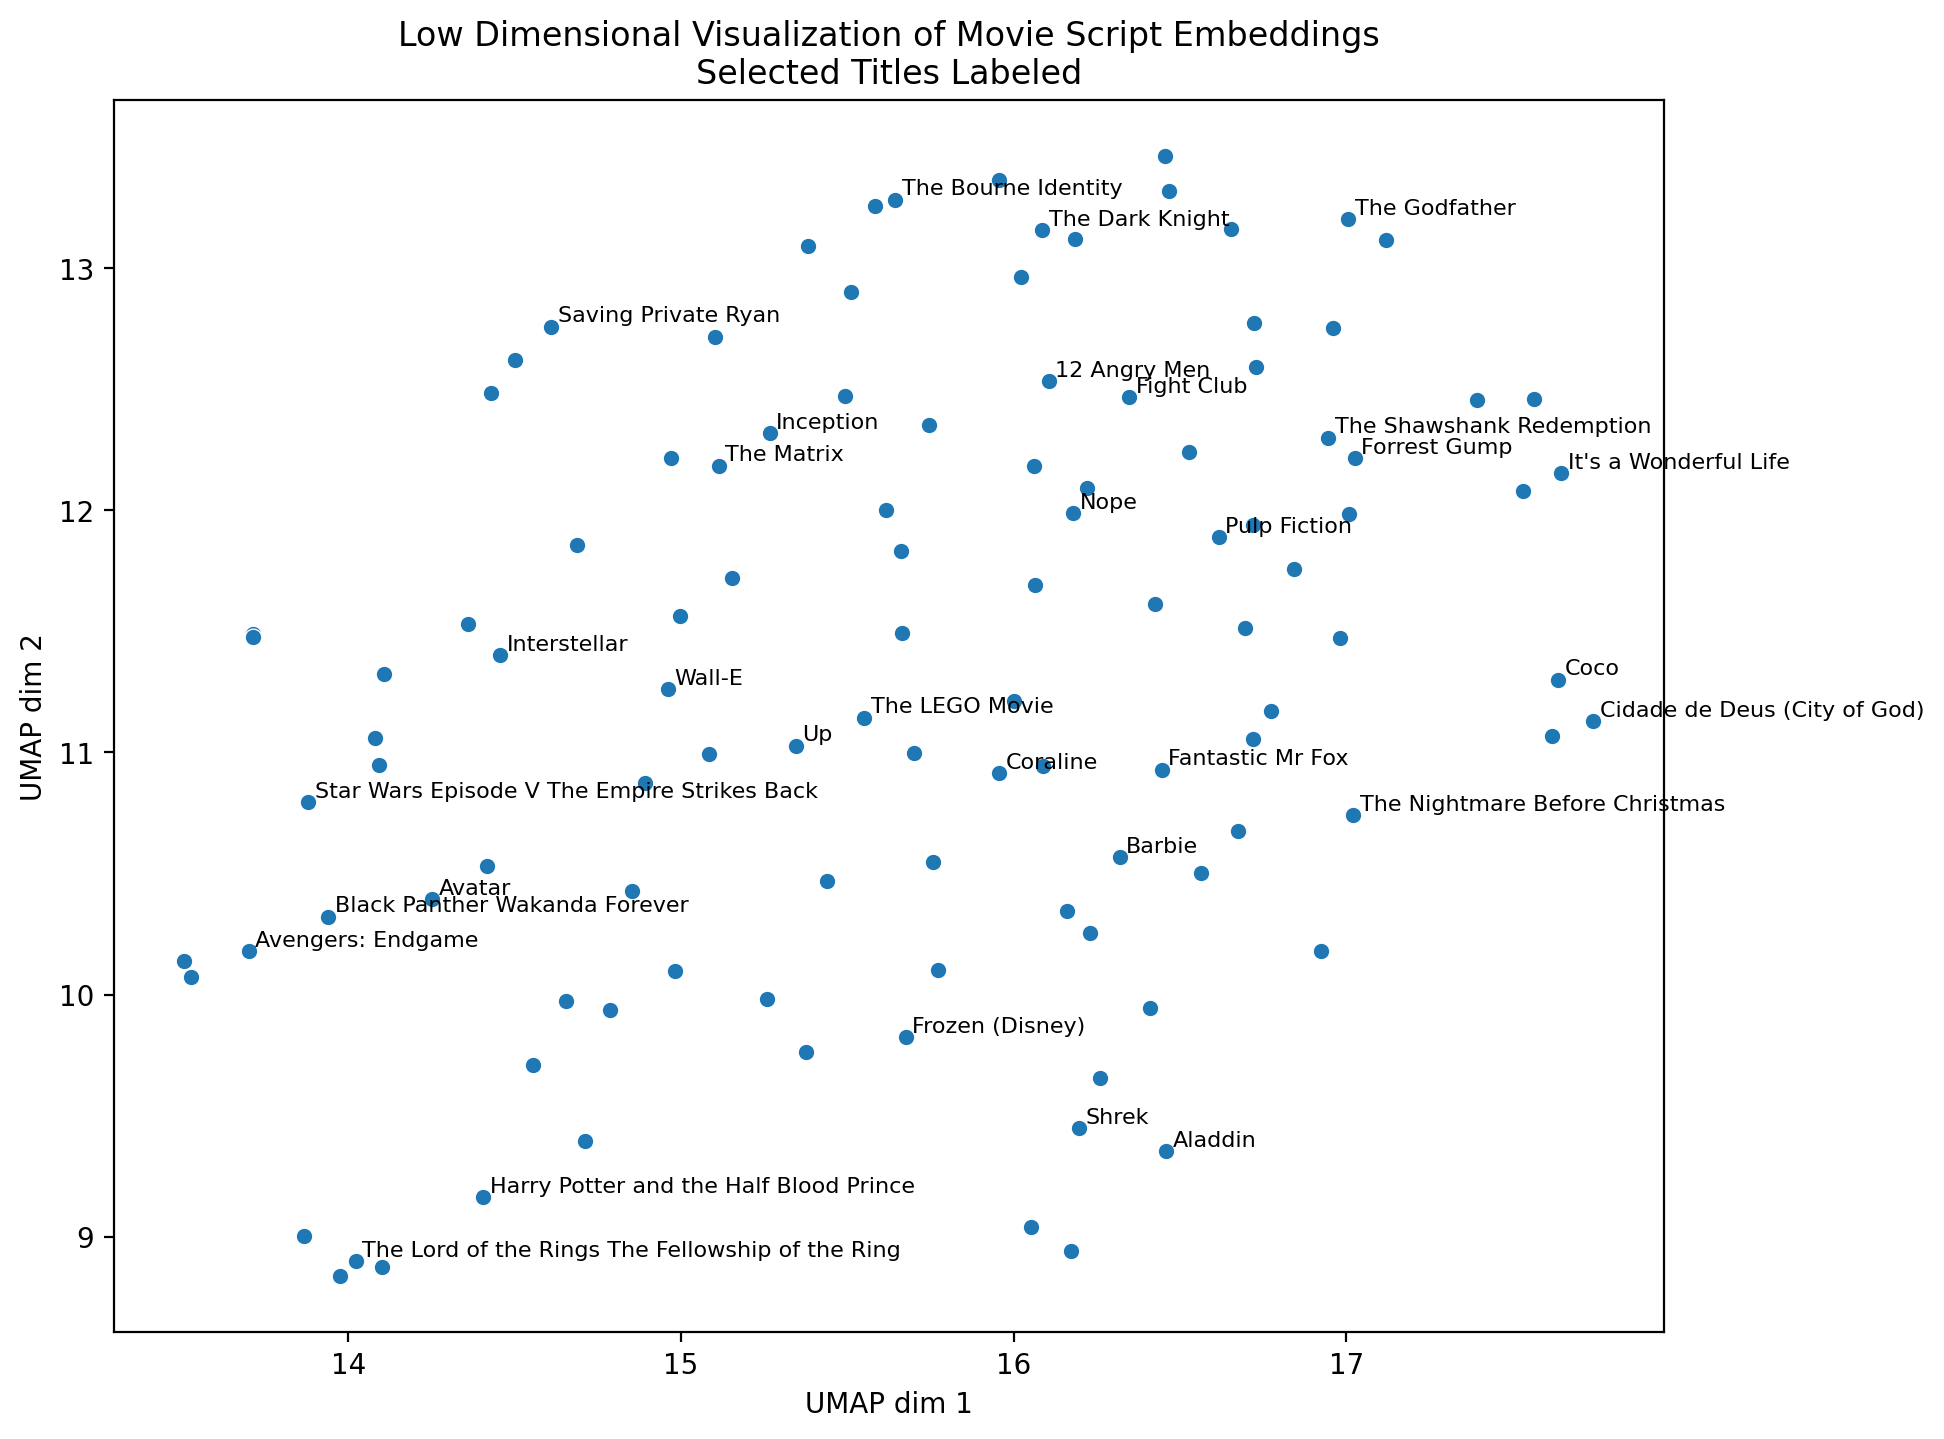

In [128]:
movies_to_label_on_plot = emblow.filter(pl.col("movie_title").is_in(label_movies))
# feel free to use emblow.to_pandas() if you
# are more comfortable with that package

fig, ax = plt.subplots( figsize=(10,8), dpi=200)

ax.set_title("Low Dimensional Visualization of Movie Script Embeddings\nSelected Titles Labeled")

sns.scatterplot(
    emblow,
    x='x',
    y='y'
)

ax.set_xlabel("UMAP dim 1")
ax.set_ylabel("UMAP dim 2")

for i in range(movies_to_label_on_plot.shape[0]):
    ax.text(
        movies_to_label_on_plot[i, 'x'] + 0.02,            # small offset in x
        movies_to_label_on_plot[i, 'y'] + 0.02,            # small offset in y
        movies_to_label_on_plot[i, 'movie_title'], 
        fontsize=8
    )
plt.show()


In [126]:
emblow.filter(
    (pl.col("x") < 16.5) & (pl.col("y") > 13)
)

index,x,y,movie_title,year,genre,main_genre,script_length
u32,f32,f32,str,i32,str,str,u32
1,16.456184,13.462613,"""15 Minutes""",2001,"""Action,Crime,Drama,Thriller""","""Crime""",34160
7,16.467606,13.321717,"""A Most Violent Year""",2015,"""Action,Crime,Drama""","""Crime""",33605
23,16.185177,13.121685,"""The Batman""",2022,"""Action,Crime,Drama""","""Crime""",195691
26,15.643629,13.28309,"""The Bourne Identity""",2002,"""Action,Adventure,Drama,Mystery…","""Thriller""",33575
27,15.383046,13.091467,"""The Bourne Supremacy""",2004,"""Action,Adventure,Drama,Mystery…","""Thriller""",34348
28,15.582981,13.259553,"""The Bourne Ultimatum""",2007,"""Action,Adventure,Mystery,Thril…","""Thriller""",33946
37,16.086512,13.157573,"""The Dark Knight""",2008,"""Action,Crime,Drama""","""Crime""",174351
91,15.957433,13.364153,"""Se7en""",1995,"""Crime,Drama,Mystery""","""Crime""",204431


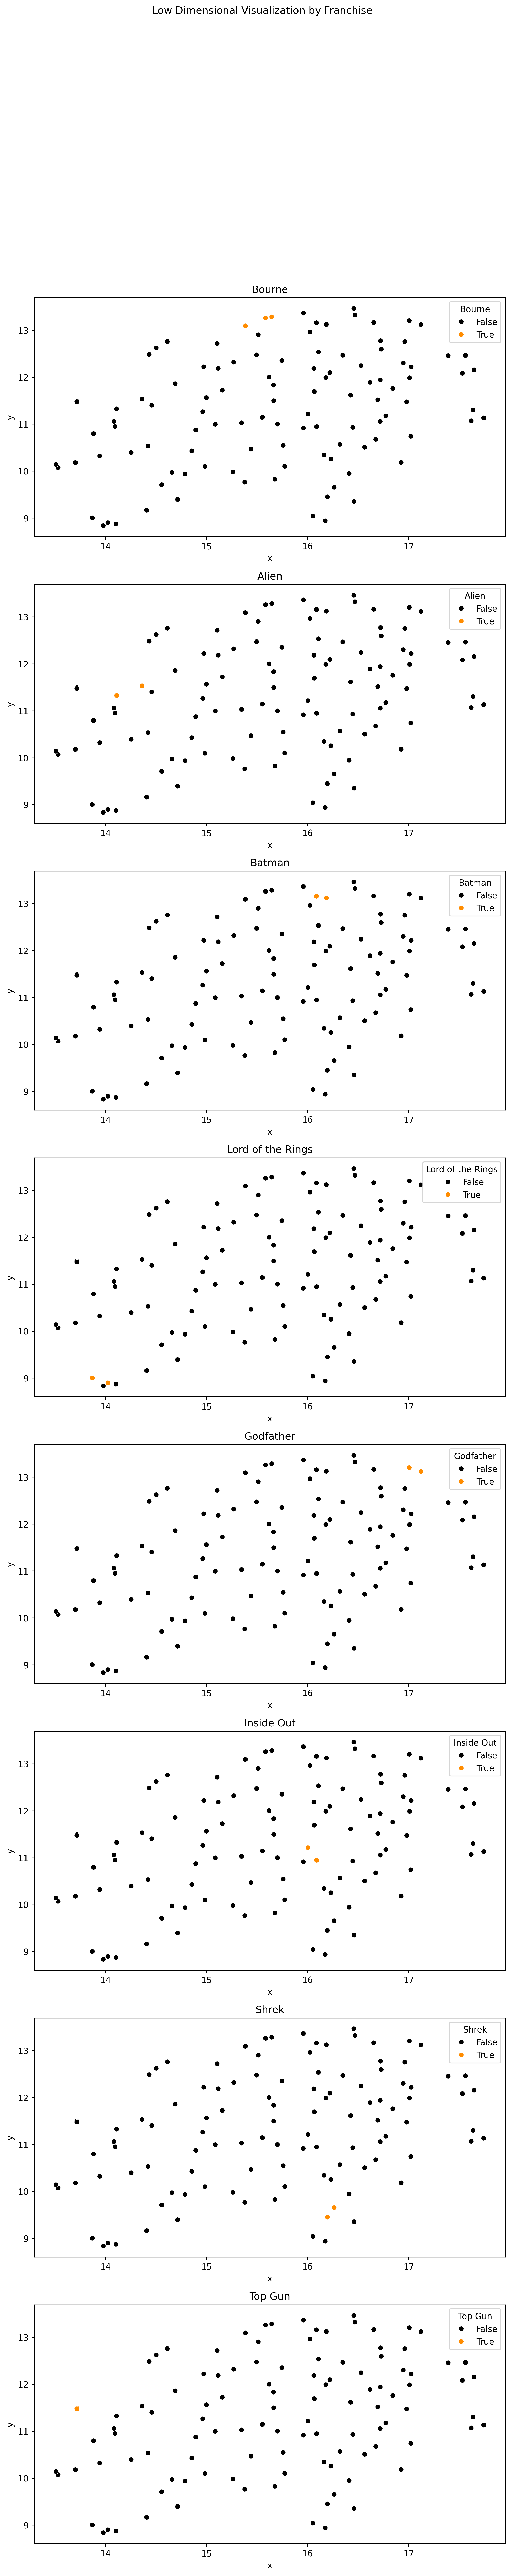

In [83]:
franchises = [
    "Bourne",
    "Alien",
    "Batman",
    "Lord of the Rings",
    "Godfather",
    "Inside Out",
    "Shrek",
    "Top Gun"
]

nplots = len(franchises)

fig, axes = plt.subplots(nplots,1,figsize=(10,6*nplots), dpi=300)
fig.suptitle("Low Dimensional Visualization by Franchise")

for i in range(nplots):

    sns.scatterplot(
        emblow.with_columns(
            pl.col("movie_title").str.replace("The Dark Knight", "Batman").str.contains(franchises[i])
            .alias(franchises[i])
        ),
        x='x',
        y='y',
        hue=franchises[i],
        ax=axes[i],
        palette=["k", "darkorange"]
    )
    axes[i].set_title(franchises[i])
    
plt.show()

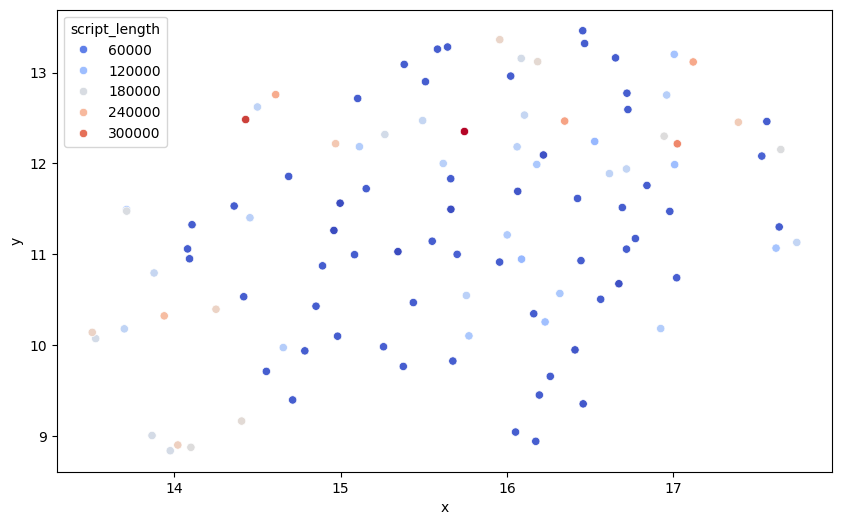

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow,
    x='x',
    y='y',
    hue='script_length',
    palette='coolwarm'
)

plt.show()

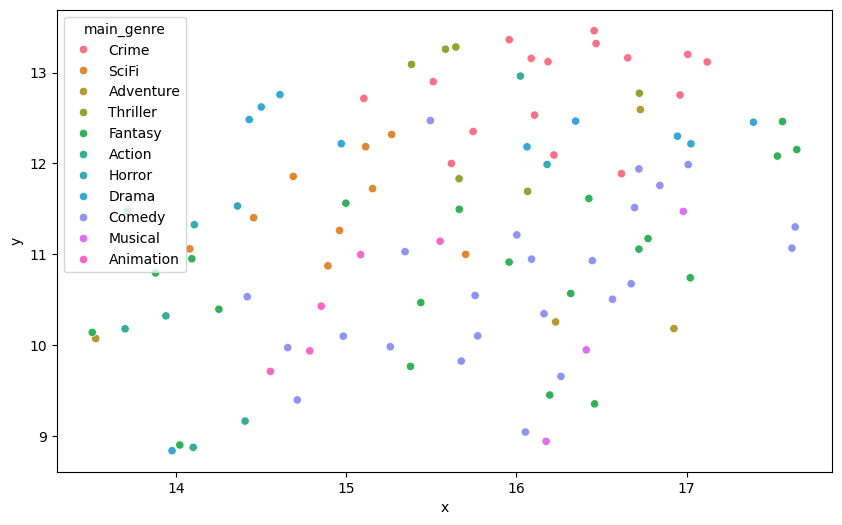

In [65]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow.with_columns(
        pl.col("genre").str.contains("Animation").alias("Action_Movie")
    ),
    x='x',
    y='y',
    hue='main_genre'
)

plt.show()